# Concatenate JSON files

In [44]:
import os
import json

In [45]:
# Set your input and output paths
input_dir = r"..\segmentation_outputs"
output_file = "merged_annotations.json"

# Initialize combined COCO structure
merged = {
    "info": {"description": "Merged COCO Dataset"},
    "images": [],
    "annotations": [],
    "categories": [],
}

# Track ID offsets and category mappings
image_id_offset = 0
ann_id_offset = 0
category_set = {}
category_map = {}

In [46]:
# Collect unique categories from all files
for filename in os.listdir(input_dir):
    if not filename.endswith(".json"):
        continue
    with open(os.path.join(input_dir, filename)) as f:
        data = json.load(f)
    for cat in data.get("categories", []):
        if cat["id"] not in category_set:
            category_set[cat["id"]] = cat
            category_map[cat["id"]] = cat["id"]  # No remap here

merged["categories"] = list(category_set.values())

In [47]:
# Merge images and annotations from each file
for filename in os.listdir(input_dir):
    if not filename.endswith(".json"):
        continue
    with open(os.path.join(input_dir, filename)) as f:
        data = json.load(f)

    local_img_id_map = {}

    # Update image IDs
    for img in data["images"]:
        new_img_id = image_id_offset + img["id"]
        local_img_id_map[img["id"]] = new_img_id
        img["id"] = new_img_id
        merged["images"].append(img)

    # Update annotation IDs and link to new image IDs
    for ann in data["annotations"]:
        ann["id"] = ann_id_offset + ann["id"]
        ann["image_id"] = local_img_id_map[ann["image_id"]]
        merged["annotations"].append(ann)

    image_id_offset = max(img["id"] for img in merged["images"]) + 1
    ann_id_offset = max(ann["id"] for ann in merged["annotations"]) + 1

In [48]:
# Save the merged dataset
with open(output_file, "w") as f:
    json.dump(merged, f)

print(f"Saved merged COCO JSON to: {output_file}")

Saved merged COCO JSON to: merged_annotations.json


# Convert COCO to YOLO format

In [49]:
import os
import json
import numpy as np
import cv2
from pycocotools import mask as maskUtils

In [50]:
# Paths
coco_json = "merged_annotations.json"  # your merged file
image_root_dir = r"..\segmentation_outputs"
output_label_dir = "labels"  # output YOLO txt files
os.makedirs(output_label_dir, exist_ok=True)

In [51]:
# Load COCO JSON
with open(coco_json, "r") as f:
    coco = json.load(f)

# Map image ID to image info
image_id_map = {img["id"]: img for img in coco["images"]}

# Category ID mapping to class index
category_map = {cat["id"]: idx for idx, cat in enumerate(coco["categories"])}

# Group annotations by image
image_to_anns = {}
for ann in coco["annotations"]:
    if ann.get("iscrowd", 0) == 1 or "segmentation" not in ann:
        continue
    image_to_anns.setdefault(ann["image_id"], []).append(ann)

In [52]:
for image_id, anns in image_to_anns.items():
    image_info = image_id_map[image_id]
    file_name = image_info["file_name"]
    file_stem = os.path.splitext(file_name)[0]
    width, height = image_info["width"], image_info["height"]

    label_lines = []

    for ann in anns:
        class_id = 0
        rle = ann["segmentation"]

        # Decode RLE mask
        if isinstance(rle, dict):
            binary_mask = maskUtils.decode(rle).astype(np.uint8)
        else:
            continue

        # Find contours from mask
        contours, _ = cv2.findContours(
            binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        for contour in contours:
            if len(contour) < 3:
                continue
            contour = contour.squeeze(1)
            norm_points = []
            for x, y in contour:
                norm_x = x / width
                norm_y = y / height
                norm_points.extend([f"{norm_x:.6f}", f"{norm_y:.6f}"])
            line = f"{class_id} " + " ".join(norm_points)
            label_lines.append(line)

    # Save YOLO label
    label_path = os.path.join(output_label_dir, f"{file_stem}.txt")
    with open(label_path, "w") as f:
        f.write("\n".join(label_lines))

# Visualize Contour

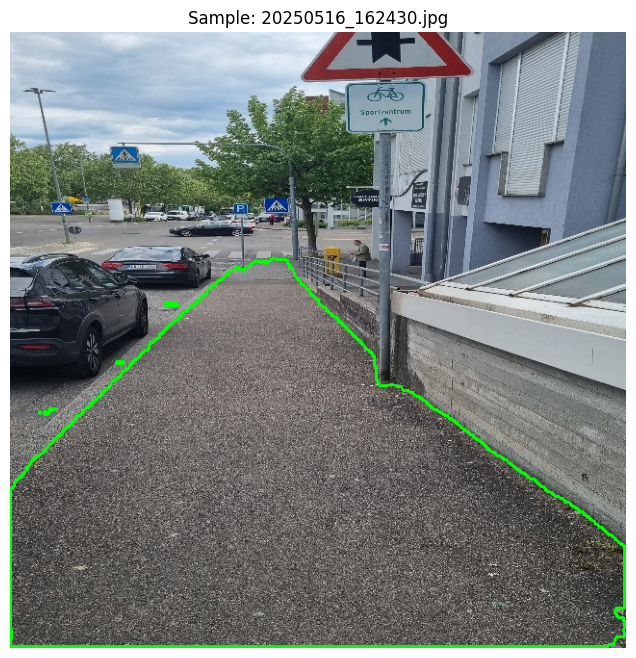

In [63]:
import matplotlib.pyplot as plt
import random

# === Configuration ===
sample_image_name = random.choice(
    os.listdir(image_root_dir)
)  # random image for inspection
image_path = os.path.join(image_root_dir, sample_image_name)
label_path = os.path.join(
    output_label_dir, os.path.splitext(sample_image_name)[0] + ".txt"
)

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# Draw polygons
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            points = np.array(parts[1:], dtype=float).reshape(-1, 2)
            points = (points * [w, h]).astype(int)

            # Draw filled polygon
            cv2.polylines(
                image, [points], isClosed=True, color=(0, 255, 0), thickness=2
            )
else:
    print("Label file not found for:", sample_image_name)

# Display
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f"Sample: {sample_image_name}")
plt.axis("off")
plt.show()

# Dataset Split & Setup

In [30]:
import os
import shutil
import random
from glob import glob

In [31]:
# === Input Dataset Path ===
base_dataset_path = "dataset"  # contains 'images/' and 'labels/'

# === Output Path ===
output_path = "yolo_dataset"
splits = ["train", "val", "test"]

# === Create Folder Structure ===
for split in splits:
    os.makedirs(os.path.join(output_path, "images", split), exist_ok=True)
    os.makedirs(os.path.join(output_path, "labels", split), exist_ok=True)

In [35]:
# Get all image files in 'images' folder
image_paths = glob(os.path.join(base_dataset_path, "images", "*.*"))

# Filter images that have corresponding label files
filtered_image_paths = []

for img_path in image_paths:
    file_stem = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(base_dataset_path, "labels", f"{file_stem}.txt")
    if os.path.exists(label_path):
        filtered_image_paths.append(img_path)

image_paths = filtered_image_paths

# Shuffle dataset for randomness
random.shuffle(image_paths)

# Compute split sizes
total = len(image_paths)
train_size = int(total * 0.7)
val_size = int(total * 0.15)

train_files = image_paths[:train_size]
val_files = image_paths[train_size : train_size + val_size]
test_files = image_paths[train_size + val_size :]

print(f"Total images: {total}")
print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Total images: 583
Train: 408, Val: 87, Test: 88


In [36]:
def copy_files(file_list, split_name):
    for img_path in file_list:
        file_stem = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(base_dataset_path, "labels", f"{file_stem}.txt")

        dst_img = os.path.join(
            output_path, "images", split_name, os.path.basename(img_path)
        )
        dst_lbl = os.path.join(output_path, "labels", split_name, f"{file_stem}.txt")

        shutil.copy2(img_path, dst_img)
        shutil.copy2(label_path, dst_lbl)


copy_files(train_files, "train")
copy_files(val_files, "val")
copy_files(test_files, "test")

print("Files copied into train, val, and test folders successfully.")

Files copied into train, val, and test folders successfully.


In [38]:
import yaml

data_yaml = {
    "train": os.path.abspath(os.path.join(output_path, "images", "train")),
    "val": os.path.abspath(os.path.join(output_path, "images", "val")),
    "test": os.path.abspath(os.path.join(output_path, "images", "test")),
    "nc": 1,  # number of classes; change if more
    "names": ["sidewalk"],  # list of class names
}

yaml_path = os.path.join(output_path, "data.yaml")

with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"Created data.yaml at: {yaml_path}")

Created data.yaml at: yolo_dataset\data.yaml
